Compare resulting hydro coefficients from systematically varying qualities of the slant, such as cross section or slope.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import time

import capytaine as cpt

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

import pickle

In [2]:
# capytaine function definitions, ignore this
solver = cpt.BEMSolver()

# use to get rid of prints
def deafen(function, *args, **kwargs):
    real_stdout = sys.stdout
    try:
        sys.stdout = open(os.devnull, "w")
        output = function(*args, **kwargs)
    finally:
        sys.stdout = real_stdout
    return output

def timed_solve(problem, reps):
    t_lst = []
    for i in range(reps):
        t0 = time.perf_counter()
        result = solver.solve(problem, keep_details = True)
        t1 = time.perf_counter()
        t_lst.append(t1 - t0)
    tdiff = sum(t_lst)/reps
    return result, tdiff

def get_points(a, d_in, d_out): # These points define the outline of the body
    pt_lst = [(0, - d_in[0])]
    for i in range(len(a)):
        pt_lst.append((a[i], - d_out[i]))
        if i < (len(a) - 1): # not last body region
            if d_out[i] != d_in[i + 1]: # vertical face exists
                pt_lst.append((a[i], - d_in[i + 1]))
        else: # need vertical face to water surface
            pt_lst.append((a[i], 0))
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heave_status, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heave_status:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    heave_region = -1
    for i in range(len(pts) - 1):
        p1, p2 = pts[i], pts[i + 1]
        if p1[0] != p2[0]: # face spans some horizontal distance
            heave_region += 1 # advance to next region
            # make a horizontal face
            meshes, mask, panel_ct = faces_and_heaves(heaving[heave_region], p1, p2, f_densities[i], t_densities[heave_region], meshes, mask, panel_ct)
        else: # make a vertical face
            if p1[1] < p2[1]: # body on inside
              j = heave_region # defer to variables of inner region
            else: # body on outside
              j = heave_region + 1 # defer to variables of outer region
            meshes, mask, panel_ct = faces_and_heaves(heaving[j], p1, p2, f_densities[i], t_densities[j], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, mesh = meshes) # unclosed boundary warnings
    # , lid_mesh = meshes.generate_lid() # consider adding lid mesh to above function
    return body, panel_ct, mask

def construct_and_solve(a, d_in, d_out, heaving, t_densities, face_units, h, m0, rho, reps):
    pt_lst = get_points(a, d_in, d_out)
    f_densities = get_f_densities(pt_lst, face_units)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    # body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result, t_diff = timed_solve(rad_problem, reps)

    diff_problem = cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result_d, t_diff_d = timed_solve(diff_problem, reps)

    # print("Panel Count: ", panel_count)
    # print(result.added_mass)
    # print(result.radiation_damping)
    # print("Solve Time (Radiation): ", t_diff)
    # print("Solve Time (Diffraction): ", t_diff_d)
    # print("Excitation Phase: ", get_excitation_phase(result_d))
    return result, t_diff, result_d, t_diff_d, panel_count

In [22]:
configurations = []

h = 15
a = [2, 4]
d_in = [6, 6]
d_out_init = [6]
m0 = 0.9
rho = 1023

for i in range(2, 11, 1):
  config = {"name" : "config-(" + str(i) + ")",
            "h" : h,
            "a" : a,
            "d_in" : d_in,
            "d_out" : d_out_init + [i],
            "heaving": [1, 1],
            "NMK" : [50, 50],
            "m0" : m0,
            "rho" : rho}
  configurations.append(config)


In [3]:
def compute_cpt_slant(config):
  t_densities = [30, 60]
  respack = construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp

In [ ]:
for config in configurations:
  am, dp = compute_cpt_slant(config)
  config["AM"] = am
  config["DP"] = dp

with open("data/cpt-slant-variations-1.pkl", "wb") as f:
  pickle.dump(configurations, f)

In [20]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

In [25]:
def plot_hydros(x, configurations, key, xlabel):
  hydros = []
  for config in configurations:
    hydros.append(config[key])

  plt.plot(x, hydros, color = "blue", linestyle = "-")

  if xlabel == "theta":
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(np.pi / 8))
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))

  # Labels and title
  plt.xlabel(xlabel)
  plt.ylabel(key)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()

def format_func(value, tick_number):
    frac = 1 / 8
    multiple = round(value / (np.pi * frac))
    num = multiple
    denom = int(1 / frac)

    if multiple == 0:
        return "0"

    # Reduce the fraction
    common = np.gcd(abs(num), denom)
    num //= common
    denom //= common

    if denom == 1:
        coeff = f"{num}" if abs(num) != 1 else ("-" if num == -1 else "")
        return rf"${coeff}\pi$"
    else:
        coeff = "-" if num < 0 else ""
        num_string = "" if abs(num) == 1 else abs(num)
        return rf"${coeff}\frac{{{num_string}\pi}}{{{denom}}}$"

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_25981/1093122763.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


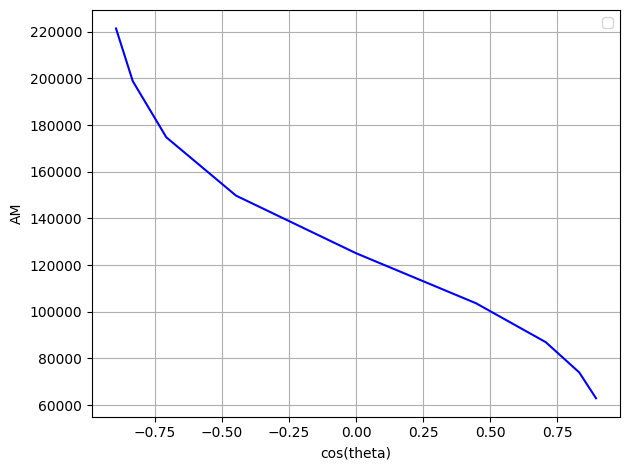

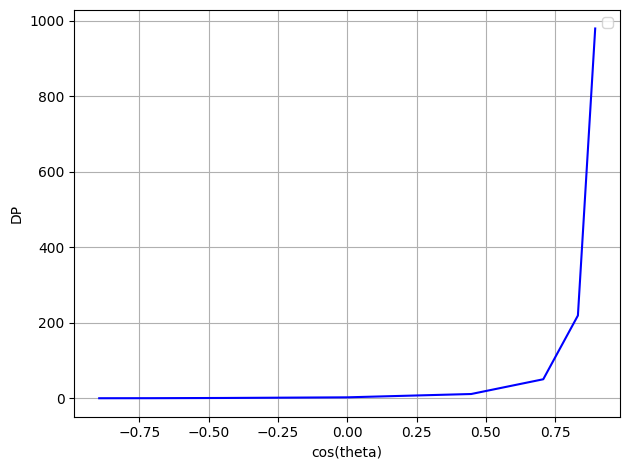

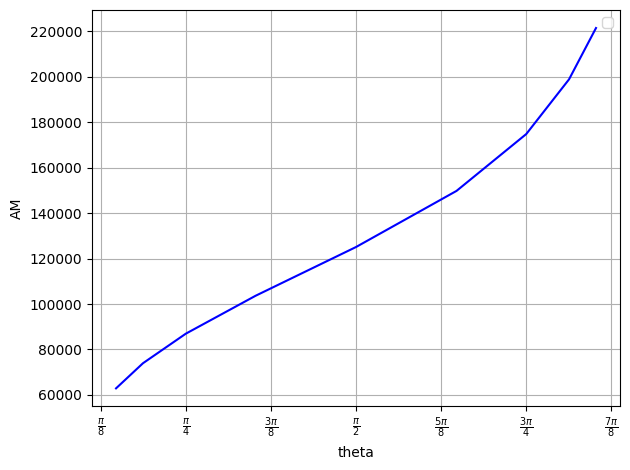

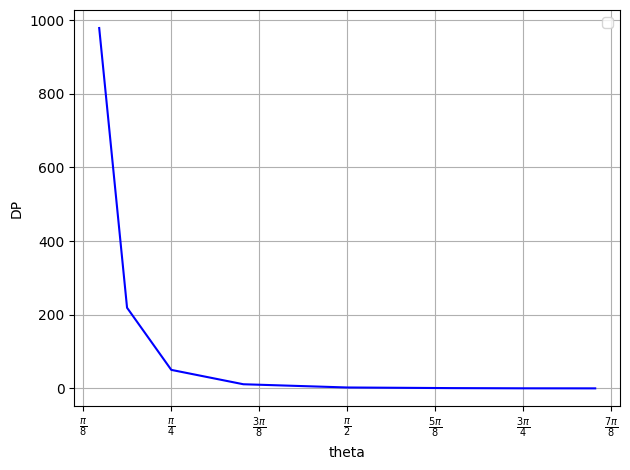

In [26]:
with open("data/cpt-slant-variations-1.pkl", "rb") as f:
  configurations = pickle.load(f)

cos_theta = []
theta = []
for config in configurations:
  delta_r = 2
  delta_z = 6 - (config["d_out"][1])
  ct = delta_z/(np.sqrt(delta_z ** 2 + delta_r ** 2))
  cos_theta.append(ct)
  theta.append(np.arccos(ct))

plot_hydros(cos_theta, configurations, "AM", "cos(theta)")
plot_hydros(cos_theta, configurations, "DP", "cos(theta)")
plot_hydros(theta, configurations, "AM", "theta")
plot_hydros(theta, configurations, "DP", "theta")


In [8]:
configurations = []

h = 15
a_init = [2]
d_in = [4, 4]
d_out_init = [4]
m0 = 0.9
rho = 1023

for i in range(6):
  config = {"name" : "config-(" + str(3+i) + ")",
            "h" : h,
            "a" : a_init + [3 + i],
            "d_in" : d_in,
            "d_out" : d_out_init + [3.5 - i * 0.5],
            "heaving": [1, 1],
            "NMK" : [50, 50],
            "m0" : m0,
            "rho" : rho}
  configurations.append(config)

In [10]:
for config in configurations:
  am, dp = compute_cpt_slant(config)
  config["AM"] = am
  config["DP"] = dp

with open("data/cpt-slant-variations-2.pkl", "wb") as f:
  pickle.dump(configurations, f)

In [11]:
def compute_cpt_box(config):
  t_densities = [30, 60]
  respack = construct_and_solve(config["a"], config["d_out"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp

for config in configurations:
  am, dp = compute_cpt_box(config)
  config["AM Boxed"] = am
  config["DP Boxed"] = dp

with open("data/cpt-slant-variations-2.pkl", "wb") as f:
  pickle.dump(configurations, f)

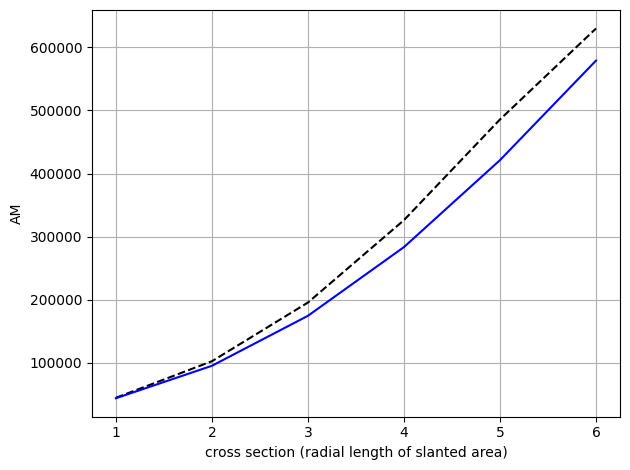

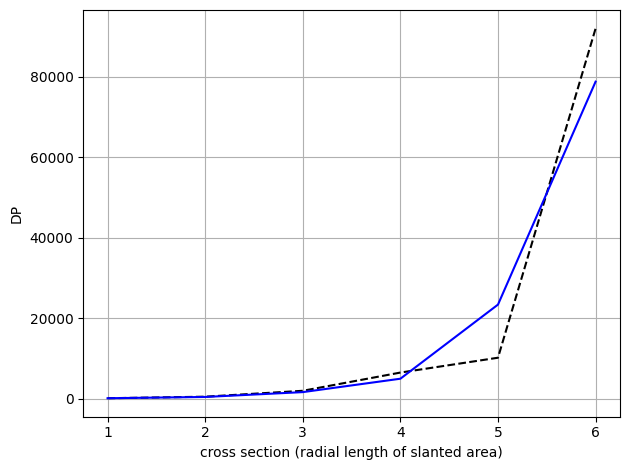

In [ ]:
def plot_hydros_with_boxed(x, configurations, key, xlabel):
  hydros = []
  hydros_boxed = []
  for config in configurations:
    hydros.append(config[key])
    hydros_boxed.append(config[key + " Boxed"])

  plt.plot(x, hydros_boxed, color = "black", linestyle = "--")
  plt.plot(x, hydros, color = "blue", linestyle = "-")

  # Labels and title
  plt.xlabel(xlabel)
  plt.ylabel(key)
  # plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()

with open("data/cpt-slant-variations-2.pkl", "rb") as f:
  configurations = pickle.load(f)

delta_rs = []
for config in configurations:
  delta_r = config["a"][1] - config["a"][0]
  delta_rs.append(delta_r)

plot_hydros_with_boxed(delta_rs, configurations, "AM", "cross section (radial length of slanted area)")
plot_hydros_with_boxed(delta_rs, configurations, "DP", "cross section (radial length of slanted area)")